# Feature extraction

In [1]:
# Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import sys
import matplotlib.pyplot as plt
from master_data_functions.functions import *
from master_models.pretrained import pretrained_model
%load_ext autoreload
%autoreload 2

/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'

In [2]:
# Import data

# File import
# Sample filenames are:
# CeBr10kSingle_1.txt -> single events, 
# CeBr10kSingle_2.txt -> single events
# CeBr10k_1.txt -> mixed single and double events 
# CeBr10.txt -> small file of 10 samples
# CeBr2Mil_Mix.txt -> 2 million mixed samples of simulated events

# Flag import, since we can now import 200k events from .npy files
from_file = False
if from_file:

    folder = "simulated"
    filename = "CeBr2Mil_Mix.txt"
    num_samples = 2e5
    #folder = "sample"
    #filename = "CeBr10k_1.txt"
    #num_samples = 1e3

    data = import_data(folder=folder, filename=filename, num_samples=num_samples)
    images = data[filename]["images"]
    energies = data[filename]["energies"]
    positions = data[filename]["positions"]
    labels = to_categorical(data[filename]["labels"])
    n_classes = labels.shape[1]
else:
    images = load_feature_representation("images_noscale_200k.npy")
    energies = load_feature_representation("energies_noscale_200k.npy")
    positions = load_feature_representation("positions_noscale_200k.npy")
    labels = load_feature_representation("labels_noscale_200k.npy")

n_classes = labels.shape[1]
print("Number of classes: {}".format(n_classes))
print("Input Images shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
print("Labels shape: {}".format(labels.shape))

# VGG16 expects 3 channels. Solving this by concatenating the image data 
# to itself, to form three identical channels

#images = np.concatenate((images, images, images), axis=3)
print("Reshaped Images data shape: {}".format(images.shape))

Number of classes: 2
Input Images shape: (200000, 16, 16, 1)
Energies shape: (200000, 2)
Positions shape: (200000, 4)
Labels shape: (200000, 2)
Reshaped Images data shape: (200000, 16, 16, 1)


In [3]:
# Scale the images
images = normalize_image_data(images)

In [4]:
#concatenate to itself to give it 3 channels
images = np.concatenate((images, images, images), axis=3)

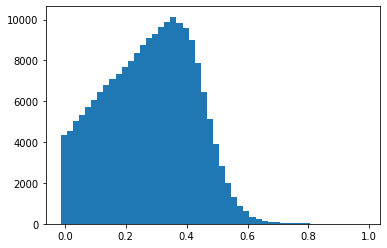

In [5]:
# Get max intensity for each image
max_intensities = np.amax(images[:,:,:,0], axis=(1,2))
plt.hist(max_intensities, bins=50)
plt.show()

## Save feature representations for all models

In [6]:
# Keys: model names, Values: depth to compare at.
pretrained_models = {
    #"DenseNet121":None, #8
    #"DenseNet169":None, #8
    #"DenseNet201":None, #8
    #"InceptionResNetV2":None, #8
    #"InceptionV3":None, #8
    #"MobileNet":None, #8
    #"MobileNetV2":None, #5
    #"NASNetLarge":None, #4
    #"NASNetMobile":None, #4
    "ResNet50":None, #8
    "VGG16":None,
    "VGG19":None,
    "Xception":None, #6
    }

## Save feature representations

In [ ]:

for net, depth in pretrained_models.items():
    print("Running for:", net)
    # Build net at desired depth
    pretrained = pretrained_model(which_model=net, output_depth=depth)
    
    # Extract features and split them into single and double
    pretrained_features = pretrained.predict(images)
    
    if depth is None:
        depth = "full"
    features_filename = net + "_d" + str(depth) + "_" + str(pretrained_features.shape[0]) + "_new_" +".npy"
    save_feature_representation(pretrained_features, features_filename)
    
    # Delete to free memory for next iteration just in case
    del pretrained_features



## Test feature distribution

In [7]:
# Define Kolmogorov-Smirnov test
from scipy.stats import ks_2samp
from joblib import Parallel, delayed
# Check difference using Kolmogorov-Smirnov

def get_pval(i):
    ks = ks_2samp(pretrained_features[single_features][:,i], pretrained_features[double_features][:,i])
    return ks.pvalue


### Kolmogorov-Smirnov 2-sample test for all networks

In [8]:
# Run test on all pretrained nets.
p_output = {}


for net, depth in pretrained_models.items():
    print("Running for:", net)
    
    # Load features
    if depth is None:
        depth = "full"
    features_filename = net + "_d" + str(depth) + "_" + str(labels.shape[0]) + "_new_" + ".npy"
    pretrained_features = load_feature_representation(features_filename)
    print(pretrained_features.shape)
    single_features = np.where(labels[:,0] == 1)[0]
    double_features = np.where(labels[:,1] == 1)[0]
    n = pretrained_features.shape[1]
    p_values = Parallel(n_jobs=-1, verbose=2)(delayed(get_pval)(i) for i in range(n))
    p_output[net] = p_values
    #plt.close()
    #plt.plot(range(len(p_values)), p_values, label=net)
    #plt.legend()
    #plt.savefig(net + "-p-vals.png")
    
    # Delete allocated arrays for saving memory in notebook
    del pretrained_features
    del single_features
    del double_features

Running for: ResNet50
(200000, 4096)


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
E0929 14:28:29.387433 140090139449088 _base.py:627] exception calling callback for <Future at 0x7f6953ac1470 state=finished raised TerminatedWorkerError>
Traceback (most recent call last):
  File "/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/joblib/externals/loky/_base.py", line 625, in _invoke_callbacks
    callback(self)
  File "/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/joblib/parallel.py", line 309, in __call__
    self.parallel.dispatch_next()
  File "/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/joblib/parallel.py", line 731, in dispatch_next
    if not self.dispatch_one_batch(self._original_iterator):
  File "/home/geir/git/master_analysis/notebooks/pretrained/pretrained_venv/lib/python3.6/site-packages/joblib/parallel.py", line 759, in dispatch_one_bat

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker. The exit codes of the workers are {SIGKILL(-9)}

### Output table of KS 2-sample test results

In [ ]:
# Get number of p-values below thresholds for each net to check
# if it's reasonable to reject the null-hypothesis (no difference in distributions)
ks_statistics = []
for key, val in p_output.items():
    pvals = np.array(p_output[key])
    n_features = len(pvals)
    n_below_1 = len(np.where(pvals < 0.01)[0])
    n_below_05 = len(np.where(pvals < 0.005)[0])
    n_below_01 = len(np.where(pvals < 0.001)[0])
    ks_statistics.append(
        [key, 
         n_features, 
         n_below_1/n_features,
         n_below_05/n_features,
         n_below_01/n_features,
        ]
    )


In [ ]:
from tabulate import tabulate
# Output as latex table
headers = ["Network", "num_features", "ratio p < 0.01", "ratio p < 0.005", "ratio p < 0.001"]
print(tabulate(ks_statistics, headers, tablefmt="latex"))

#### Compare single events and close double events
'Close' double events are events separated by a distance less than 3 mm.
This length is chose because that is the width of one pixel in the image data, and
it is below this distance that the models seem to struggle the most.

In [ ]:
# Run test on all pretrained nets.
p_output = {}


for net, depth in pretrained_models.items():
    print("Running for:", net)
    
    # Load features
    if depth is None:
        depth = "full"
    features_filename = net + "_d" + str(depth) + "_" + str(images.shape[0]) + ".npy"
    pretrained_features = load_feature_representation(features_filename)
    single_features = pretrained_features[np.where(labels[:,0] == 1)]
    single_indices, double_indices, close_indices = event_indices(positions)
    double_features = pretrained_features[close_indices]
    n = pretrained_features.shape[1]
    p_values = Parallel(n_jobs=-1, verbose=2)(delayed(get_pval)(i) for i in range(n))
    p_output[net] = p_values
    
    #plt.close()
    #plt.plot(range(len(p_values)), p_values, label=net)
    #plt.legend()
    #plt.savefig(net + "_close" + "-p-vals.png")
    
    # Delete allocated arrays for saving memory in notebook
    del pretrained_features
    del single_features
    



In [ ]:
# Get number of p-values below thresholds for each net to check
# if it's reasonable to reject the null-hypothesis (no difference in distributions)
ks_statistics = []
for key, val in p_output.items():
    pvals = np.array(p_output[key])
    n_features = len(pvals)
    n_below_1 = len(np.where(pvals < 0.01)[0])
    n_below_05 = len(np.where(pvals < 0.005)[0])
    n_below_01 = len(np.where(pvals < 0.001)[0])
    ks_statistics.append(
        [key, 
         n_features, 
         n_below_1/n_features,
         n_below_05/n_features,
         n_below_01/n_features,
        ]
    )

In [ ]:
# Output as latex table
print(len(close_indices))
headers = ["Network", "num_features", "ratio p < 0.01", "ratio p < 0.005", "ratio p < 0.001"]
print(tabulate(ks_statistics, headers, tablefmt="latex"))

In [ ]:
print(len(single_indices))
print(len(double_indices))
print(len(close_indices))

## (Optional) Plot features for some samples

In [ ]:
manual_inspect = False
if manual_inspect:
    # Compare feature output for reference image with a single and double image
    plt.plot(range(len(reference_features[0])), reference_features[0], alpha=0.5, label='reference')
    plt.plot(range(len(single_features[0])), single_features[0], alpha=0.5, label='single')
    plt.plot(range(len(double_features[0])), double_features[0], alpha=0.5, label='double')
    plt.legend()
    plt.show()
    
    # Check distribution of features by inspection
    index = 0 
    fig, ax = plt.subplots(3, 3, sharex='col', sharey='row', figsize=(12,12))
    for i in range(3):
        for j in range(3):
            # plot features
            ax[i, j].hist(single_features[:,index + i*3 + j], alpha=0.5, label='single')
            ax[i, j].hist(double_features[:,index + i*3 + j], alpha=0.5, label='double')
            ax[i, j].hist(ref_vgg_features, alpha=0.5, label='reference')
            ax[i, j].legend()
    plt.show()